In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, KNNBasic, accuracy, SVD, SVDpp
from implicit.als import AlternatingLeastSquares
from collections import defaultdict

c:\Users\Maxim\miniconda3\envs\surprise\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
ratings = pd.read_csv('Ratings.csv')
books = pd.read_csv('Books.csv')
users = pd.read_csv('Users.csv')

# Preview the data
print("Ratings sample:")
print(ratings.head(5))
print("\nBooks sample:")
print(books[['ISBN','Book-Title','Book-Author','Year-Of-Publication','Publisher']].head(3))
print("\nUsers sample:")
print(users.head(3))

C:\Users\Maxim\AppData\Local\Temp\ipykernel_21656\167715065.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv')


Ratings sample:
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

Books sample:
         ISBN            Book-Title           Book-Author Year-Of-Publication  \
0  0195153448   Classical Mythology    Mark P. O. Morford                2002   
1  0002005018          Clara Callan  Richard Bruce Wright                2001   
2  0060973129  Decision in Normandy          Carlo D'Este                1991   

                 Publisher  
0  Oxford University Press  
1    HarperFlamingo Canada  
2          HarperPerennial  

Users sample:
   User-ID                         Location   Age
0        1               nyc, new york, usa   NaN
1        2        stockton, california, usa  18.0
2        3  moscow, yukon territory, russia   NaN


In [3]:
# Remove implicit interactions (ratings == 0)
ratings_explicit = ratings[ratings['Book-Rating'] > 0].copy()

# Filter users and books with at least 5 ratings
user_counts = ratings_explicit['User-ID'].value_counts()
book_counts = ratings_explicit['ISBN'].value_counts()
filtered_ratings = ratings_explicit[
    (ratings_explicit['User-ID'].isin(user_counts[user_counts >= 15].index)) &
    (ratings_explicit['ISBN'].isin(book_counts[book_counts >= 15].index))].copy()

print("Number of ratings after removing 0s and filtering:", len(filtered_ratings))
print("Number of unique users:", filtered_ratings['User-ID'].nunique())
print("Number of unique books:", filtered_ratings['ISBN'].nunique())


Number of ratings after removing 0s and filtering: 63632
Number of unique users: 4612
Number of unique books: 3241


In [4]:
# Map user IDs and ISBNs to new indices
unique_users = filtered_ratings['User-ID'].unique()
unique_books = filtered_ratings['ISBN'].unique()
user_id_to_index = {uid: idx for idx, uid in enumerate(unique_users)}
book_id_to_index = {isbn: idx for idx, isbn in enumerate(unique_books)}

# Add new index columns to ratings dataframe
filtered_ratings['user_idx'] = filtered_ratings['User-ID'].map(user_id_to_index)
filtered_ratings['book_idx'] = filtered_ratings['ISBN'].map(book_id_to_index)


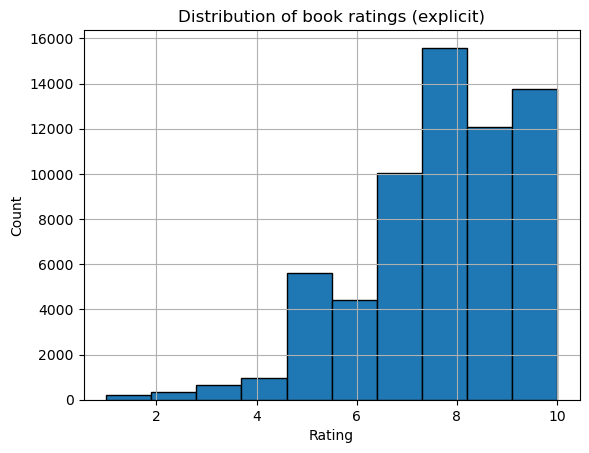

In [5]:
# Distribution of explicit ratings
plt.figure()
filtered_ratings['Book-Rating'].hist(bins=10, edgecolor='black')
plt.title('Distribution of book ratings (explicit)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [6]:
# For simplicity, do a random 80/20 split of the interactions
train_df, test_df = train_test_split(filtered_ratings, test_size=0.2, random_state=0)

# Ensure that every user in test also appears in train (cold-start users removed)
test_df = test_df[test_df['User-ID'].isin(train_df['User-ID'])]


In [7]:
# Prepare text for each book: title + author
books_filtered = books[books['ISBN'].isin(filtered_ratings['ISBN'].unique())].copy()
books_filtered['Title_Author'] = books_filtered['Book-Title'].fillna('') + ' ' + books_filtered['Book-Author'].fillna('')

# Train a TF-IDF vectorizer on the combined text of titles and authors
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
book_profiles = tfidf.fit_transform(books_filtered['Title_Author'])

print("TF-IDF matrix shape (books x features):", book_profiles.shape)

TF-IDF matrix shape (books x features): (3149, 4682)


In [8]:
# Create mapping from ISBN to its TF-IDF vector index
isbn_to_profile_index = {isbn: idx for idx, isbn in enumerate(books_filtered['ISBN'])}

# Initialize an empty matrix for user profiles
num_users = filtered_ratings['User-ID'].nunique()
profile_dim = book_profiles.shape[1]
user_profiles = np.zeros((num_users, profile_dim))

# For each user, make TF-IDF vectors of books they liked (rating >= 8)
liked_threshold = 8
train_likes = train_df[train_df['Book-Rating'] >= liked_threshold]

for uid, grp in train_likes.groupby('User-ID'):
    user_idx = user_id_to_index.get(uid)
    # Sum TF-IDF vectors of all liked books
    liked_books = grp['ISBN'].map(isbn_to_profile_index).dropna()
    if len(liked_books) == 0:
        continue
    user_profiles[user_idx] = book_profiles[liked_books].sum(axis=0)

# Normalize user profile vectors to unit length (for cosine similarity)
user_profiles = normalize(user_profiles)


In [9]:
# Normalize book vectors as well for cosine similarity
book_profiles_norm = normalize(book_profiles)

def recommend_content_based(user_id, N=5):
    uidx = user_id_to_index[user_id]
    user_vec = user_profiles[uidx]
    # Compute cosine similarity between user profile and all books
    sims = cosine_similarity(user_vec.reshape(1, -1), book_profiles_norm).flatten()
    # Exclude books the user has already rated
    seen_book_idxs = train_df[train_df['User-ID'] == user_id]['ISBN'].map(isbn_to_profile_index)
    seen_book_idxs = set(seen_book_idxs.dropna().astype(int).values)
    sims[list(seen_book_idxs)] = -1  # set seen books' similarity to -1 to exclude them
    # Get top N recommendations
    top_indices = sims.argsort()[-N:][::-1]
    top_isbns = [books_filtered.iloc[i]['ISBN'] for i in top_indices]
    top_titles = [books_filtered.iloc[i]['Book-Title'] for i in top_indices]
    return list(zip(top_isbns, top_titles))


In [10]:
sample_user = train_df['User-ID'].iloc[350]
recs = recommend_content_based(sample_user, N=5)
print(f"Content-based recommendations for user {sample_user}:")
for isbn, title in recs:
    print(f"{title} (ISBN: {isbn})")


Content-based recommendations for user 6543:
Seven Up (A Stephanie Plum Novel) (ISBN: 0312265840)
One for the Money (A Stephanie Plum Novel) (ISBN: 0312990456)
Hot Six : A Stephanie Plum Novel (A Stephanie Plum Novel) (ISBN: 0312976275)
Three To Get Deadly : A Stephanie Plum Novel (A Stephanie Plum Novel) (ISBN: 0312966091)
Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel) (ISBN: 0312983867)


In [11]:
# Prepare data for surprise
reader = Reader(rating_scale=(1, 10))
train_data = Dataset.load_from_df(train_df[['User-ID', 'ISBN', 'Book-Rating']], reader)
trainset = train_data.build_full_trainset()

In [12]:
# User-based collaborative filtering using KNNBasic
sim_options = {'name': 'pearson', 'user_based': True}  # using Pearson correlation for similarity
user_knn = KNNBasic(k=20, min_k=3, sim_options=sim_options)
user_knn.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [13]:
# Build a set of all item IDs in the trainset for reference
all_items = set(train_df['ISBN'].unique())

def recommend_surprise(algo, user_id, N=5):
    # Get the list of items the user has already interacted with in training
    seen_items = set(train_df[train_df['User-ID'] == user_id]['ISBN'])
    candidates = all_items - seen_items
    # Predict rating for each candidate
    preds = []
    for iid in candidates:
        preds.append((iid, algo.predict(user_id, iid).est))
    # Sort candidates by predicted rating
    preds.sort(key=lambda x: x[1], reverse=True)
    topN = preds[:N]
    # Return list of (ISBN, predicted_rating)
    return topN

In [ ]:
# Item-based collaborative filtering
sim_options_item = {'name': 'pearson', 'user_based': False}
item_knn = KNNBasic(k=20, min_k=3, sim_options=sim_options_item)
item_knn.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [24]:
recs_itemcf = recommend_surprise(item_knn, sample_user, N=5)
print(f"Item-based CF recommendations for user {sample_user}:")
for isbn, score in recs_itemcf:
    title = books.loc[books['ISBN'] == isbn, 'Book-Title'].values[0]
    print(f"{title} (predicted rating: {score:.2f})")


Item-based CF recommendations for user 275020:
Shopgirl : A Novella (predicted rating: 7.90)
Chicken Soup for the Couple's Soul (Chicken Soup for the Soul) (predicted rating: 7.90)
Die Unertragliche Leichtigkeit des Seins...The Unbearable Lightness of Being (predicted rating: 7.90)
The Ultimate Hitchhiker's Guide (predicted rating: 7.90)
The Partner (predicted rating: 7.90)


In [16]:
# SVD matrix factorization
svd_algo = SVD(n_factors=50, reg_all=0.02, n_epochs=20)  # 50 latent factors as an example
svd_algo.fit(trainset)

# SVD++ model
svdpp_algo = SVDpp(n_factors=50, reg_all=0.02, n_epochs=20)
svdpp_algo.fit(trainset)

In [17]:
# Example: predict a rating for a given user and book
user_example = test_df['User-ID'].iloc[350]
book_example = test_df['ISBN'].iloc[350]
print("Actual rating in test:", test_df[(test_df['User-ID']==user_example)&(test_df['ISBN']==book_example)]['Book-Rating'].values)
print("SVD predicted rating:", svd_algo.predict(user_example, book_example).est)
print("SVD++ predicted rating:", svdpp_algo.predict(user_example, book_example).est)
# Top-5 recommendations
recs_svd = recommend_surprise(svd_algo, sample_user, N=5)
recs_svdpp = recommend_surprise(svdpp_algo, sample_user, N=5)
print("SVD Top-5 recommendations:", [books.loc[books['ISBN']==isbn, 'Book-Title'].values[0] for isbn, _ in recs_svd])
print("SVD++ Top-5 recommendations:", [books.loc[books['ISBN']==isbn, 'Book-Title'].values[0] for isbn, _ in recs_svdpp])

Actual rating in test: [7]
SVD predicted rating: 7.225937246686927
SVD++ predicted rating: 7.051756290351743
SVD Top-5 recommendations: ['The Return of the King (The Lord of the Rings, Part 3)', 'The Two Towers (The Lord of the Rings, Part 2)', "My Sister's Keeper : A Novel (Picoult, Jodi)", 'Harry Potter and the Chamber of Secrets Postcard Book', "Charlotte's Web (Trophy Newbery)"]
SVD++ Top-5 recommendations: ['Snow Falling on Cedars', 'The Return of the King (The Lord of the Rings, Part 3)', 'Harry Potter and the Prisoner of Azkaban (Book 3)', 'Gone with the Wind', 'One Hundred Years of Solitude']


In [18]:
# Create a user-item interaction matrix for implicit feedback
n_users = max(train_df['user_idx']) + 1
n_items = max(train_df['book_idx']) + 1
# Treat all explicit interactions as 1 for implicit feedback.
weights = train_df.copy()
weights['rating_weight'] = 1
user_item_matrix = sp.csr_matrix((weights['rating_weight'], (weights['user_idx'], weights['book_idx'])), shape=(n_users, n_items))

# Train ALS model
als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=15)
als_model.fit(user_item_matrix.tocsr())

c:\Users\Maxim\miniconda3\envs\surprise\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\Maxim\miniconda3\envs\surprise\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
100%|██████████| 15/15 [00:00<00:00, 43.73it/s]


In [19]:
# Example recommendations with ALS
sample_user = test_df['User-ID'].iloc[350]
user_index = user_id_to_index[sample_user]
recommended_items, scores = als_model.recommend(user_index, user_item_matrix[user_index], N=10)
print(f"ALS implicit recommendations for User {sample_user}:")
for item_idx, score in zip(recommended_items, scores):
    isbn = unique_books[item_idx]
    title = books.loc[books['ISBN'] == isbn, 'Book-Title'].values[0]
    print(f"{title} (score: {score:.3f})")

ALS implicit recommendations for User 275020:
Girl with a Pearl Earring (score: 0.075)
The Pilot's Wife : A Novel (score: 0.068)
The Secret Life of Bees (score: 0.052)
House of Sand and Fog (score: 0.047)
Life of Pi (score: 0.047)
The Catcher in the Rye (score: 0.040)
The Vampire Lestat (Vampire Chronicles, Book II) (score: 0.036)
To Kill a Mockingbird (score: 0.036)
Bridget Jones: The Edge of Reason (score: 0.035)
She's Come Undone (Oprah's Book Club) (score: 0.033)


In [25]:
# Build testset for surprise algorithms
testset = list(zip(test_df['User-ID'], test_df['ISBN'], test_df['Book-Rating']))

# Predict on testset for surprise algos
userknn_preds = user_knn.test(testset)
itemknn_preds = item_knn.test(testset)
svd_preds = svd_algo.test(testset)
svdpp_preds = svdpp_algo.test(testset)

print("UserKNN RMSE:", accuracy.rmse(userknn_preds, verbose=False))
print("ItemKNN RMSE:", accuracy.rmse(itemknn_preds, verbose=False))
print("SVD RMSE:", accuracy.rmse(svd_preds, verbose=False))
print("SVD++ RMSE:", accuracy.rmse(svdpp_preds, verbose=False))


UserKNN RMSE: 1.776982128553747
ItemKNN RMSE: 1.6992040142081277
SVD RMSE: 1.5431194992799022
SVD++ RMSE: 1.5587185259649128


In [ ]:
# First, build a dictionary of test items for each user (ground truth)
test_items_by_user = defaultdict(list)
for uid, iid in zip(test_df['User-ID'], test_df['ISBN']):
    test_items_by_user[uid].append(iid)

def recall_at_k(model_recommend_func, k=10):
    hits = 0
    total = 0
    for user, true_items in test_items_by_user.items():
        total += len(true_items)
        # Get top-k recommended item IDs for this user
        recs = model_recommend_func(user, k)
        rec_items = [iid for iid, score in recs] if recs else []
        # Count hits
        for true_item in true_items:
            if true_item in rec_items:
                hits += 1
    return (hits / total)

# Define recommend functions for each model
def rec_userknn(user, k): return recommend_surprise(user_knn, user, N=k)
def rec_itemknn(user, k): return recommend_surprise(item_knn, user, N=k)
def rec_svd(user, k): return recommend_surprise(svd_algo, user, N=k)
def rec_svdpp(user, k): return recommend_surprise(svdpp_algo, user, N=k)
def rec_als(user, k):
    uindex = user_id_to_index[user]
    item_indexes, scores = als_model.recommend(uindex, user_item_matrix[uindex], N=k)
    return [(unique_books[j], float(s)) for j, s in zip(item_indexes, scores)]
def rec_content(user, k):
    recs = recommend_content_based(user, N=k)
    return [(isbn, 1.0) for isbn, title in recs]  # similarity not important for recall

In [26]:
print("Recall@10:")
print("Content-based:", recall_at_k(rec_content, 10))
print("User-based CF:", recall_at_k(rec_userknn, 10))
print("Item-based CF:", recall_at_k(rec_itemknn, 10))
print("SVD:", recall_at_k(rec_svd, 10))
print("SVD++:", recall_at_k(rec_svdpp, 10))
print("ALS (implicit):", recall_at_k(rec_als, 10))


Recall@10:
Content-based: 0.05977485333756144
User-based CF: 0.01680672268907563
Item-based CF: 0.01696527667670842
SVD: 0.00459806564135088
SVD++: 0.009275408276518154
ALS (implicit): 0.07317266529253211
